### import modules


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import gsw
import math
from scipy.optimize import fmin
import scipy
import os
import gzip
#import cmocean
#import h5py
from geographiclib.geodesic import Geodesic
from tqdm import tqdm
from matplotlib.path import Path
import gc as GarbageCollector
    
import os
from memory_profiler import memory_usage
def get_memory_usage():
    mem_usage = memory_usage(-1, interval=0.1, timeout=1)
    return max(mem_usage)

from LabSea_functions_and_variables import ll2km, rotate_point, rotate_point_corr
from LabSea_functions_and_variables import lat_line_0, lon_line_0, lat_line_1, lon_line_1, lat_line_A, lon_line_A

# to update changesin loaded functions
#%load_ext autoreload
#%autoreload 2

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher
#argo_loader = ArgoDataFetcher(mode='research')

In [3]:
#!pip install git+https://github.com/euroargodev/argopy.git@master
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Load and process Argo Data

In [4]:
def clear_array_of_nan(x):
  return x[~np.isnan(x)]

class ArgoDataProcessor:
    def __init__(self, filename):
        self.dataset = xr.open_dataset(filename)
        self.filtered_indices = None

    def find_profiles_near_line(self, lon0, lat0, bbox, distance=75):
        lon_km, lat_km = ll2km(self.dataset.LONGITUDE.values, self.dataset.LATITUDE.values, bbox)
        lon_r, lat_r = rotate_point_corr(lon_km, lat_km)

        I = np.where(lat_km.ravel() >= -60)
        J = np.where(lon_km.ravel() >= 0)
        i75 = np.where((lat_r >= -distance) & (lat_r <= distance))
        K = np.intersect1d(i75, I, J)

        bool_array = np.zeros_like(self.dataset.LONGITUDE.values, dtype=bool)
        bool_array[K] = True
        self.filtered_indices = bool_array

    def apply_filter(self):
        if self.filtered_indices is not None:
            self.dataset = self.dataset.isel(N_PROF=self.filtered_indices)

class BathymetryPlotter:
    def __init__(self, topo_filename):
        topo_data = np.load(topo_filename)
        self.lon_topo = topo_data['lon_topo']
        self.lat_topo = topo_data['lat_topo']
        self.bathy = topo_data['bathy']

    def plot_bathymetry_and_argo(self, argo_dataset):
        ranges = np.arange(0, 5400, 500)
        fig, ax = plt.subplots(figsize=(6, 7))
        plt.contour(self.lon_topo, self.lat_topo, self.bathy, ranges, colors='grey', linewidths=1)
        plt.contour(self.lon_topo, self.lat_topo, self.bathy, [0], colors='k', linewidths=1)
        plt.contour(self.lon_topo, self.lat_topo, self.bathy, [1000], colors='b', linewidths=1)

        plt.plot(argo_dataset.LONGITUDE.values, argo_dataset.LATITUDE.values, '.r')
        plt.plot(lon_line_A, lat_line_A, 'k')
        plt.plot(lon_line_1, lat_line_1, ':k')
        plt.plot(lon_line_0, lat_line_0, ':k')

        contour_path = Path(plt.gca().collections[2].get_paths()[1].vertices)
        contour_collection = plt.gca().collections[2]
        contour_paths = [path for path in contour_collection.get_paths()]

        points_within_contour = np.zeros(len(argo_dataset.LONGITUDE.values), dtype=bool)
        for path in contour_paths:
            contour_path = Path(path.vertices)
            points_within_contour |= contour_path.contains_points(np.column_stack((argo_dataset.LONGITUDE.values, argo_dataset.LATITUDE.values)))

        plt.plot(argo_dataset.LONGITUDE.values[points_within_contour], argo_dataset.LATITUDE.values[points_within_contour], 'og', markersize=3)
        plt.show()

        bool_array_2 = np.zeros_like(argo_dataset.LONGITUDE.values, dtype=bool)
        bool_array_2[points_within_contour] = True
        return bool_array_2


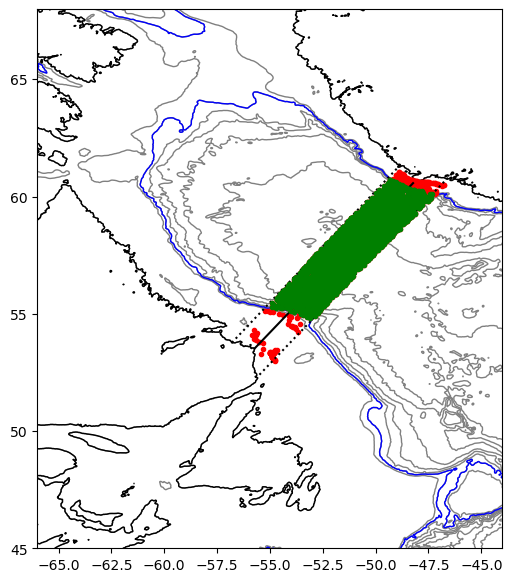

In [5]:
argo_processor = ArgoDataProcessor('LabSea_Argo_2002_2023.nc')

Lon0, Lat0 = -55.73, 53.517        #round, zero point at coast along line
bbox= [Lon0, -44 , Lat0, 68]
argo_processor.find_profiles_near_line(Lon0, Lat0, bbox) # lon0, lat0, bbox= [Lon0, -44 , Lat0, 68]
argo_processor.apply_filter()

bathymetry_plotter = BathymetryPlotter('LabSea_topo_Argo.npz')
filter_indices = bathymetry_plotter.plot_bathymetry_and_argo(argo_processor.dataset)

# If needed, apply the second filter based on bathymetry
ag = argo_processor.dataset.isel(N_PROF=filter_indices)


In [8]:
def calc_percentile_of_R(Rz):
  dist = np.arange(-500,500,0.1)

  gauss = np.exp(-np.sqrt(( (dist / Rz)**2)**2  ))
  cdf = np.cumsum(gauss)
  cdf = cdf / cdf[-1]

  percentile_95 = np.interp(0.95, cdf, dist)

  return percentile_95

### Define Processor class for OI over x and z chunks

In [9]:
class OiChunksProcessor:
    
    def __init__(self, ag, bbox, lamb, R_params, cuts_z, overlap_z, spacing_z, xstart, xend, step_x=50, overlap_x=10, spacing_x=2.5, maxNum=3000):
        
        self.ag = ag
        self.bbox = bbox
        self.lamb = lamb
        self.R_params = R_params
        
        self.xstart = xstart
        self.xend = xend
        self.step_x = step_x
        self.overlap_x = overlap_x
        self.spacing_x = spacing_x
        self.spacing_z = spacing_z

        self.maxNum = maxNum

        self.cuts_z = cuts_z
        self.overlap_z = overlap_z
        
        self.ivec = np.arange(0, len(self.overlap_z),1)

        # Initialize arrays to collect results
        self.rows = (self.xend-self.xstart)/self.spacing_x + 1
        self.cols = len(np.arange(cuts_z[0], cuts_z[-1] + self.spacing_z, self.spacing_z))
        self.thetaT = np.zeros([int(self.cols), int(self.rows)])
        self.thetaS = np.zeros([int(self.cols), int(self.rows)])
        self.error = np.zeros([int(self.cols), int(self.rows)])
        self.perc_list = []

        #self.residuals = { 'res': [],}
        
        self.xbin_edges = np.array([[self.xstart + i * self.step_x, self.xstart + (i + 1) * self.step_x] for i in range(int((self.xend - self.xstart) // self.step_x))])
        self.slice_overlap = round(self.overlap_x / self.spacing_x)
        self.slices_x = slice(self.slice_overlap, -self.slice_overlap)

        # cuts_z = np.array([0, 250,500,750,1375,2000])
        self.iChunks = np.array(overlap_z) / self.spacing_z
        self.iz = self.cuts_z / self.spacing_z

        self.select_rdm = False

    def calc_zbins(self):
        
        zbins_positive = np.array([[self.cuts_z[i] - self.overlap_z[i], self.cuts_z[i+1] + self.overlap_z[i]] for i in range(0,len(self.overlap_z))])
        zbins_positive[0][0] = 0
        zbins_positive[-1][1] = 2000
        
        z_arrays = [np.arange(z[0], z[1] + spacing_z, spacing_z)*(-1) for z in zbins_positive]
        
        zbins = np.array([[(self.cuts_z[i+1] + self.overlap_z[i])*(-1), (self.cuts_z[i] - self.overlap_z[i])*(-1)] for i in range(0,len(self.overlap_z))])
        zbins[0][1]  = 0
        zbins[-1][0] = -2000

        #print(z_arrays)
        
        return zbins, z_arrays

    
    def load_variables(self):
        
        N, M = len(self.ag.N_PROF.values), len(self.ag.N_LEVELS.values)
        lon_data = np.tile(self.ag.LONGITUDE.values[:, np.newaxis], (1, M))
        lat_data = np.tile(self.ag.LATITUDE.values[:, np.newaxis], (1, M))
        SA_data = self.ag.SA.values[:,::2]
        temp_data = self.ag.CT.values[:,::2]
        depth_data = gsw.z_from_p(self.ag.PRES.values[:,::2], lat_data[:,::2])
        pres_data = self.ag.PRES.values[:,::2]

        lat_data = lat_data[:,::2]
        lon_data = lon_data[:,::2]

        long_km, lati_km = ll2km(lon_data, lat_data, self.bbox)
        x_data, lati_kmr = rotate_point_corr(long_km, lati_km)
        #print(x_data.min(),x_data.max())

        return map(np.ravel, [x_data, temp_data, SA_data, depth_data, pres_data, lon_data, lat_data])

    def process_xbins(self):
        
        x_data, temp_data, SA_data, depth_data, pres_data, lon_data, lat_data = self.load_variables()
        
        xi0 = 0
        xs  = self.step_x / self.spacing_x + 1
        xi1 = xs
        
        for i in tqdm(range(len(self.xbin_edges)), total=len(self.xbin_edges), colour='green'):

            '''
            if i  == 0:
              Add_start = 0
              Add_end   = self.overlap_x
            elif i == len(self.xbin_edges):
              Add_end = 0
              Add_start = self.overlap_x
            else:
              Add_end   = self.overlap_x
              Add_start = self.overlap_x
              '''

            Add_start = self.overlap_x
            Add_end   = self.overlap_x
            
            #print(self.xbin_edges[i][0],self.xbin_edges[i][1])

            xbin_start, xbin_end = self.xbin_edges[i][0] - Add_start, self.xbin_edges[i][1] + Add_end
                
            if i > 0:
                x = np.arange( self.xbin_edges[i][0] + self.spacing_x, self.xbin_edges[i][1] + self.spacing_x, self.spacing_x).astype(np.float32)
            else:
                x = np.arange( self.xbin_edges[i][0], self.xbin_edges[i][1] + self.spacing_x, self.spacing_x).astype(np.float32)

            df = pd.DataFrame({
                'x': x_data,
                'temp': temp_data,
                'SA': SA_data,
                'depth': depth_data,
                'pres': pres_data,
                'lon': lon_data,
                'lat': lat_data
            })

            # Filter data for current x-bin
            df = df[(df['x'] >= xbin_start ) & (df['x'] < xbin_end )]

            zbins, z_arrays = self.calc_zbins()

            # Now process each z-bin within the current x-bin
            thetaT_list =  []
            thetaS_list =  []
            err_list = []
            
            for j, zbin, R, z, iChunk in zip(self.ivec, zbins, self.R_params, z_arrays, self.iChunks): #, total=len(zbins), colour='red'):
                
                theta_z, theta_s, err_z = self.process_zbins(df, zbin, R, z, x, int(iChunk), int(j))
                thetaT_list.append(theta_z)
                thetaS_list.append(theta_s)
                err_list.append(err_z)
                
            
            #print(np.concatenate(theta_list).shape)
            self.thetaT[:,int(xi0):int(xi1)] = np.concatenate(thetaT_list)
            self.thetaS[:,int(xi0):int(xi1)] = np.concatenate(thetaS_list)
            self.error[:,int(xi0):int(xi1)] = np.concatenate(err_list)
 
            xi0 = xi0 + xs 
            
            if i == 0:
                xs = xs - 1

            xi1 = xi1 + xs
            
            # Manual memory management
            del df  # Delete the DataFrame to free up memory
            GarbageCollector.collect()  # Explicitly invoke garbage collection

        
    def process_zbins(self, df, zbin, R, z, x, iChunk, i):

            df['bin0'] = pd.cut(df['depth'], zbin, include_lowest=True)
            zg = df.dropna()

            # Convert data to float32 for optimization
            tempZ, SAZ, z_dataZ, x_dataZ, lon_dataZ, lat_dataZ = [zg[col].values.astype(np.float32) for col in ['temp', 'SA', 'depth', 'x', 'lon', 'lat']]

            if (self.select_rdm == True) & (len(tempZ) > self.maxNum):

                percentage = round(self.maxNum/len(tempZ), 3)
                self.perc_list.append(percentage)
                
                sample_size = int(len(tempZ) * percentage)

                # Generate random indices
                random_indices = np.random.choice(len(tempZ), sample_size, replace=False)

                # Subsample arrays using the same indices
                tempZ = tempZ[random_indices]
                SAZ = SAZ[random_indices]
                x_dataZ = x_dataZ[random_indices]
                z_dataZ = z_dataZ[random_indices]
        
    
            # Perform the interpolation/optimization with corresponding R
            ret_t = self.optinter_2D(R, self.lamb, x, z, tempZ, SAZ, x_dataZ, z_dataZ, cov_func='gauss')

            print('Current memory usage {:.2f} GB'.format( get_memory_usage() / 1024))
        
            if i == 0:
            
                thetaT = ret_t['thetaT'][0:-iChunk-1,:]
                thetaS = ret_t['thetaS'][0:-iChunk-1,:]
                error = ret_t['error'][0:-iChunk-1,:]
                #res = ret_t['residual']
            
            elif i == len(self.ivec)-1:
               
                thetaT = ret_t['thetaT'][iChunk:,:]
                thetaS = ret_t['thetaS'][iChunk:,:]
                error = ret_t['error'][iChunk:,:]
                #res = ret_t['residual']

            else:
                thetaT = ret_t['thetaT'][iChunk:-iChunk-1,:]
                thetaS = ret_t['thetaS'][iChunk:-iChunk-1,:]
                error = ret_t['error'][iChunk:-iChunk-1,:]
                #res = ret_t['residual']
                #print(z[iChunk:-iChunk])

            return thetaT, thetaS, error


            # Manual memory management
            del zg, tempZ, SAZ, z_dataZ, x_dataZ, lon_dataZ, lat_dataZ
            
            GarbageCollector.collect()


    def optinter_2D(self, R, lamb, x, z, data1, data2, xdata, zdata, cov_func='gauss'):

        X, Z = np.meshgrid(x, z)

        # Ars.
        xr, zr = np.meshgrid(xdata, zdata)

        # Compute the distance of each data point:
        # Gaussian: exp(-rdist**2)
        # Markov: ( 1+ rdist) * exp(-rdist)
        # rdist = np.sqrt(((xr - xr.T) / R[0])**2 + ((zr - zr.T) / R[1])**2 )

        # Covariance function.
        if cov_func == 'gauss':
            cdd0 = np.exp(-np.sqrt(((xr - xr.T) / R[0])**2 + ((zr - zr.T) / R[1])**2 )**2 )
        elif cov_func == 'markov':
            cdd0 = (1 + np.sqrt(((xr - xr.T) / R[0])**2 + ((zr - zr.T) / R[1])**2 )) * np.exp(-np.sqrt(((xr - xr.T) / R[0])**2 + ((zr - zr.T) / R[1])**2 ))
        else:
            raise ValueError("Unrecognized covariance function {!r}."
                            "Must be one of 'gauss' or 'markov'.".format(cov_func))

        # Final Data covariance Matrix between data points.
        cdd = cdd0 + lamb * np.eye(*cdd0.shape)

        # Cxr.
        Xd, Xg = np.meshgrid(xdata, X.ravel())
        Zd, Zg = np.meshgrid(zdata, Z.ravel())

        # Distance between observation r and grid g.
        # Gaussian: exp(-rmd**2)
        # Markov: ( 1+ rmd) * exp(-rmd)
        # rmd =  np.sqrt(((Xg - Xd) / R[0])**2 + ((Zg - Zd) / R[1])**2)

        # Again plug into covariance function.
        if cov_func == 'gauss':
            cmd = np.exp(-np.sqrt((((Xg - Xd) / R[0])**2 + ((Zg - Zd) / R[1])**2)**2  ))
        elif cov_func == 'markov':
            cmd = (1 + np.sqrt((((Xg - Xd) / R[0])**2 + ((Zg - Zd) / R[1])**2)) ) * np.exp(-np.sqrt(((Xg - Xd) / R[0])**2 + ((Zg - Zd) / R[1])**2) )
        else:
            raise ValueError("Unrecognized covariance function {!r}."
                            "Must be one of 'gauss' or 'markov'.".format(cov_func))

        demeaned1 =  data1 - data1.mean()
        demeaned2 =  data2 - data2.mean()
        #res1 = data1.mean() + np.dot(cdd0, np.linalg.solve(cdd, demeaned1))
        #res1 = data1.ravel() - res.ravel()

        # Normalized by the error variance.
        err = np.diag(1 - np.dot(np.dot(cmd, np.linalg.inv(cdd)), cmd.T))
        err = np.reshape(err, X.shape) * 100  # Error in percentages.

        thetaT = data1.mean() + np.dot(cmd, np.linalg.solve(cdd, demeaned1))
        thetaT = np.reshape(thetaT, X.shape)

        thetaS = data2.mean() + np.dot(cmd, np.linalg.solve(cdd, demeaned2))
        thetaS = np.reshape(thetaS, X.shape)
        
        print('Current memory usage {:.2f} GB'.format( get_memory_usage()/1024))

        return dict( error=err,  thetaT=thetaT, thetaS=thetaS)    #covariance=cdd0, final_covariance=cdd,


In [10]:
start = pd.to_datetime('2002-03-01')
end   = pd.to_datetime('2016-04-30')
time_mask = (ag['TIME'] >= start) & (ag['TIME'] <= end)
ag_all = ag.where(time_mask, drop=True)

In [28]:
def map_month_to_season(month):
    if month in [4, 5, 6]:
        return 'Spring'
    elif month in [7, 8,9,10,11]:
        return 'Summer'
    else:
        return 'Winter'

#seasonal_datasets = ag.groupby('TIME.month').map(map_month_to_season)
#ds['season'] = xr.apply_ufunc(assign_season, ds['time'].dt.month, vectorize=True)
ag_all['season'] = xr.apply_ufunc(map_month_to_season, ag_all.TIME.dt.month, vectorize=True)
seasonal_datasets = ag_all.groupby('season')

spring_data = seasonal_datasets['Spring']
summer_data = seasonal_datasets['Summer']
winter_data = seasonal_datasets['Winter']

In [31]:
winter_data

<xarray.Dataset>
Dimensions:          (N_PROF: 926, N_LEVELS: 1123)
Coordinates:
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 ... 1118 1119 1120 1121 1122
  * N_PROF           (N_PROF) int64 366 367 368 369 370 371 ... 163 213 53 54 55
    LATITUDE         (N_PROF) float64 57.61 57.59 57.41 ... 58.98 58.65 58.5
    LONGITUDE        (N_PROF) float64 -51.62 -51.65 -51.5 ... -49.8 -49.73
    TIME             (N_PROF) datetime64[ns] 2004-01-04T16:23:52 ... 2023-12-...
Data variables: (12/13)
    CYCLE_NUMBER     (N_PROF) float64 17.0 18.0 19.0 20.0 ... 276.0 277.0 278.0
    DIRECTION        (N_PROF) object A A A A A A A A A A ... A A A A A A A A A A
    PLATFORM_NUMBER  (N_PROF) float64 4.901e+06 4.901e+06 ... 4.902e+06
    PRES             (N_PROF, N_LEVELS) float32 4.2 9.4 19.4 ... nan nan nan
    PRES_ERROR       (N_PROF, N_LEVELS) float32 2.4 2.4 2.4 2.4 ... nan nan nan
    PSAL             (N_PROF, N_LEVELS) float32 34.78 34.78 34.78 ... nan nan
    ...               ...
    TEMP             (N_PROF, N_LEVELS) float32 3.962 3.962 3.963 ... nan nan
    TEMP_ERROR       (N_PROF) float32 0.002 0.002 0.002 ... 0.002 0.002 0.002
    CT               (N_PROF, N_LEVELS) float64 3.959 3.958 3.959 ... nan nan
    PV               (N_PROF, N_LEVELS) float64 7.377e-12 5.181e-12 ... nan nan
    SA               (N_PROF, N_LEVELS) float64 34.95 34.95 34.95 ... nan nan
    season           (N_PROF) <U6 'Winter' 'Winter' ... 'Winter' 'Winter'
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://erddap.ifremer.fr/erddap
    Fetched_by:           root
    Fetched_date:         2024/03/25
    Fetched_constraints:  [x=-66.00/-44.00; y=45.00/68.00; z=0.0/2000.0; t=20...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    history:              Variables filtered according to DATA_MODE; Variable...

In [10]:
start = pd.to_datetime('2004-01-01')
end   = pd.to_datetime('2013-12-31')
time_mask = (ag_all['TIME'] >= start) & (ag_all['TIME'] <= end)
ag_early = ag_all.where(time_mask, drop=True)

start2 = pd.to_datetime('2014-01-01')
end2   = pd.to_datetime('2023-12-31')
time_mask2 = (ag_all['TIME'] >= start2) & (ag_all['TIME'] <= end2)
ag_late = ag_all.where(time_mask2, drop=True)

In [11]:
lamb = 0.1

Rx = 150
#Rz = [250, 250, 250, 270, 270] #other Rz
#Rz = [350, 350, 350, 350, 370, 370] #higher Rz

#old RZ 
Rz = [30, 50, 80, 100, 120, 120] #Rz0
#Rz = [10, 20, 50, 50, 80, 80] #Rz1

R_params = [
    np.array([Rx, Rz[0]]),
    np.array([Rx, Rz[1]]),
    np.array([Rx, Rz[2]]),
    np.array([Rx, Rz[3]]),
    np.array([Rx, Rz[4]]),
    np.array([Rx, Rz[5]])]

spacing_z = 5
overlap_z = [np.ceil(calc_percentile_of_R(np.array(r)) / spacing_z) * spacing_z for r in Rz] # find multiple of spacing_z next higher to the 95% percentile of Rz
#overlap_z = [150, 100, 150, 150, 200]
#cuts_z = np.array([0, 250,500,750,1375,2000])
cuts_z = np.array([0, 100, 250,500,750,1375,2000])

spacing_x = 10
overlap_x = np.ceil(calc_percentile_of_R(Rx) / spacing_x) * spacing_x

xstart =  175
xend   = 925
#N = 14
step_x = 150

#percentages = []

#for k in tqdm(range(0,N), colour='blue'):

In [14]:
for strings, ds in zip(['spring', 'summer', 'winter'],[spring_data, summer_data, winter_data]):
    processor = OiChunksProcessor(ds, bbox, lamb, R_params, 
                                  cuts_z = cuts_z, 
                                  overlap_z = overlap_z,
                                  spacing_z = spacing_z, 
                                  xstart = xstart, 
                                  xend = xend, 
                                  step_x = step_x, 
                                  overlap_x = overlap_x, 
                                  spacing_x = spacing_x,
                                  maxNum = 30000)
    
    processor.process_xbins()
    
    thetaT = processor.thetaT
    thetaS = processor.thetaS
    err   = processor.error
    
    z = np.arange(0,2000 + spacing_z, spacing_z)*-1
    x = np.arange(xstart, xend + spacing_x, spacing_x)
    
    ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                                   thetaS=(["x", "z"], thetaS.T),
                                   err=(["x", "z"], err.T),    
                                       ),
    
        coords=dict(  x=x,      
                    z=z,    
                   ),
    
        attrs=dict(description="optimal interpolated temp. and salinity values and error"),)
    
    ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_2004_2023_{strings}.nc')

  0%|          | 0/5 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
xstart=475
xend=625

for n in range(2,5):
    processor = OiChunksProcessor(ag_late, bbox, lamb, R_params, 
                                  cuts_z = cuts_z, 
                                  overlap_z = overlap_z,
                                  spacing_z = spacing_z, 
                                  xstart = xstart, 
                                  xend = xend, 
                                  step_x = step_x, 
                                  overlap_x = overlap_x, 
                                  spacing_x = spacing_x,
                                  maxNum = 30000)
    
    processor.process_xbins()
    
    thetaT = processor.thetaT
    thetaS = processor.thetaS
    err   = processor.error
    
    z = np.arange(0,2000 + spacing_z, spacing_z)*-1
    x = np.arange(xstart, xend + spacing_x, spacing_x)

    if n == 0:
        ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                                       thetaS=(["x", "z"], thetaS.T),
                                       err=(["x", "z"], err.T),    
                                           ), coords=dict(  x=x,   z=z,    
                       ), attrs=dict(description="optimal interpolated temp. and salinity values and error"),)
    else:
        ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T[1:,:]),
                                       thetaS=(["x", "z"], thetaS.T[1:,:]),
                                       err=(["x", "z"], err.T[1:,:]),    
                                           ), coords=dict(  x=x[1:],   z=z,    
                       ), attrs=dict(description="optimal interpolated temp. and salinity values and error"),)
    
    ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_all_late{n}.nc')
    
xstart = xstart + 150
xend = xend + 150

  0%|          | 0/1 [00:00<?, ?it/s]

Current memory usage 59.60 GB
Current memory usage 1.34 GB
Current memory usage 142.61 GB
Current memory usage 1.72 GB


In [ ]:
processor = OiChunksProcessor(ag_all, bbox, lamb, R_params, 
                              cuts_z = cuts_z, 
                              overlap_z = overlap_z,
                              spacing_z = spacing_z, 
                              xstart = 180, 
                              xend = 930, 
                              step_x = step_x, 
                              overlap_x = overlap_x, 
                              spacing_x = spacing_x,
                              maxNum = 30000)

processor.process_xbins()

thetaT = processor.thetaT
thetaS = processor.thetaS
err   = processor.error

z = np.arange(0,2000 + spacing_z, spacing_z)*-1
x = np.arange(xstart, xend + spacing_x, spacing_x)

ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                               thetaS=(["x", "z"], thetaS.T),
                               err=(["x", "z"], err.T),    
                                   ),

    coords=dict(  x=x,      
                z=z,    
               ),

    attrs=dict(description="optimal interpolated temp. and salinity values and error"),)

ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart180_lambda_1e1_halfz_all_2002_2016.nc')

  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 6.62 GB
Current memory usage 1.00 GB
Current memory usage 14.60 GB
Current memory usage 1.24 GB
Current memory usage 17.99 GB
Current memory usage 1.38 GB
Current memory usage 11.20 GB
Current memory usage 1.41 GB
Current memory usage 15.69 GB
Current memory usage 1.63 GB
Current memory usage 6.36 GB


 20%|██        | 1/5 [08:15<33:03, 495.78s/it]

Current memory usage 1.63 GB
Current memory usage 23.78 GB
Current memory usage 1.58 GB


In [ ]:
ag_all['intensity'] = xr.apply_ufunc(map_year_to_intensity, ag_all.TIME.dt.year, vectorize=True)
intensity_dataset = ag_all.groupby('intensity')

strong_data= intensity_dataset['strong']
weak_data  = intensity_dataset['weak']

In [ ]:
processor = OiChunksProcessor(strong_data, bbox, lamb, R_params, 
                              cuts_z = cuts_z, 
                              overlap_z = overlap_z,
                              spacing_z = spacing_z, 
                              xstart = xstart, 
                              xend = xend, 
                              step_x = step_x, 
                              overlap_x = overlap_x, 
                              spacing_x = spacing_x,
                              maxNum = 30000)

processor.process_xbins()

thetaT = processor.thetaT
thetaS = processor.thetaS
err   = processor.error

z = np.arange(0,2000 + spacing_z, spacing_z)*-1
x = np.arange(xstart, xend + spacing_x, spacing_x)

ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                               thetaS=(["x", "z"], thetaS.T),
                               err=(["x", "z"], err.T),    
                                   ),

    coords=dict(  x=x,      
                z=z,    
               ),

    attrs=dict(description="optimal interpolated temp. and salinity values and error"),)

ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_all_strong.nc')

In [ ]:
processor = OiChunksProcessor(weak_data, bbox, lamb, R_params, 
                              cuts_z = cuts_z, 
                              overlap_z = overlap_z,
                              spacing_z = spacing_z, 
                              xstart = xstart, 
                              xend = xend, 
                              step_x = step_x, 
                              overlap_x = overlap_x, 
                              spacing_x = spacing_x,
                              maxNum = 30000)

processor.process_xbins()

thetaT = processor.thetaT
thetaS = processor.thetaS
err   = processor.error

z = np.arange(0,2000 + spacing_z, spacing_z)*-1
x = np.arange(xstart, xend + spacing_x, spacing_x)

ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                               thetaS=(["x", "z"], thetaS.T),
                               err=(["x", "z"], err.T),    
                                   ),

    coords=dict(  x=x,      
                z=z,    
               ),

    attrs=dict(description="optimal interpolated temp. and salinity values and error"),)

ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_all_weak.nc')

In [14]:
def map_year_to_intensity(year):
    if year in [2008, 2014, 2015, 2016, 2017, 2018, 2012, 2019,2020, 2022]:
        return 'strong'
    else:
        return 'weak'

spring_data['intensity'] = xr.apply_ufunc(map_year_to_intensity, spring_data.TIME.dt.year, vectorize=True)
intensity_dataset = spring_data.groupby('intensity')

strong_data_spring = intensity_dataset['strong']
weak_data_spring   = intensity_dataset['weak']

for strings, Ds in zip(['spring', 'summer', 'winter'],[spring_data, summer_data, winter_data]):

    Ds['intensity'] = xr.apply_ufunc(map_year_to_intensity, Ds.TIME.dt.year, vectorize=True)
    intensity_dataset = Ds.groupby('intensity')

    strong_data= intensity_dataset['strong']
    weak_data  = intensity_dataset['weak']

    processor = OiChunksProcessor(strong_data, bbox, lamb, R_params, 
                                  cuts_z = cuts_z, 
                                  overlap_z = overlap_z,
                                  spacing_z = spacing_z, 
                                  xstart = xstart, 
                                  xend = xend, 
                                  step_x = step_x, 
                                  overlap_x = overlap_x, 
                                  spacing_x = spacing_x,
                                  maxNum = 30000)
    
    processor.process_xbins()
    
    thetaT = processor.thetaT
    thetaS = processor.thetaS
    err   = processor.error
    
    z = np.arange(0,2000 + spacing_z, spacing_z)*-1
    x = np.arange(xstart, xend + spacing_x, spacing_x)
    
    ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                                   thetaS=(["x", "z"], thetaS.T),
                                   err=(["x", "z"], err.T),    
                                       ),
    
        coords=dict(  x=x,      
                    z=z,    
                   ),
    
        attrs=dict(description="optimal interpolated temp. and salinity values and error"),)
    
    ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_2004_2023_{strings}_strong.nc')

    processor2 = OiChunksProcessor(weak_data, bbox, lamb, R_params, 
                                      cuts_z = cuts_z, 
                                      overlap_z = overlap_z,
                                      spacing_z = spacing_z, 
                                      xstart = xstart, 
                                      xend = xend, 
                                      step_x = step_x, 
                                      overlap_x = overlap_x, 
                                      spacing_x = spacing_x,
                                      maxNum = 30000)
    
    processor2.process_xbins()
    
    thetaT = processor2.thetaT
    thetaS = processor2.thetaS
    err   = processor2.error
    
    z = np.arange(0,2000 + spacing_z, spacing_z)*-1
    x = np.arange(xstart, xend + spacing_x, spacing_x)
    
    ds2 = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                                   thetaS=(["x", "z"], thetaS.T),
                                   err=(["x", "z"], err.T),    
                                       ),
    
        coords=dict(  x=x,      
                    z=z,    
                   ),
    
        attrs=dict(description="optimal interpolated temp. and salinity values and error"),)
    
    ds2.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_2004_2023_{strings}_weak.nc')

  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 2.73 GB
Current memory usage 1.03 GB
Current memory usage 5.52 GB
Current memory usage 1.28 GB
Current memory usage 7.15 GB
Current memory usage 1.52 GB
Current memory usage 4.70 GB
Current memory usage 1.66 GB
Current memory usage 7.69 GB
Current memory usage 1.89 GB
Current memory usage 4.55 GB


 20%|██        | 1/5 [02:32<10:09, 152.36s/it]

Current memory usage 1.90 GB
Current memory usage 6.72 GB
Current memory usage 1.88 GB
Current memory usage 13.10 GB
Current memory usage 1.84 GB
Current memory usage 14.81 GB
Current memory usage 1.86 GB
Current memory usage 8.52 GB
Current memory usage 1.86 GB
Current memory usage 14.09 GB
Current memory usage 1.87 GB
Current memory usage 6.74 GB


 40%|████      | 2/5 [09:06<14:43, 294.52s/it]

Current memory usage 1.87 GB
Current memory usage 7.90 GB
Current memory usage 1.83 GB
Current memory usage 15.48 GB
Current memory usage 1.84 GB
Current memory usage 16.68 GB
Current memory usage 1.85 GB
Current memory usage 9.39 GB
Current memory usage 1.86 GB
Current memory usage 15.24 GB
Current memory usage 1.86 GB
Current memory usage 6.96 GB
Current memory usage 1.86 GB


 60%|██████    | 3/5 [16:50<12:23, 371.88s/it]

Current memory usage 5.75 GB
Current memory usage 1.84 GB
Current memory usage 9.97 GB
Current memory usage 1.84 GB
Current memory usage 9.85 GB
Current memory usage 1.85 GB
Current memory usage 6.14 GB
Current memory usage 1.86 GB
Current memory usage 9.78 GB
Current memory usage 1.86 GB
Current memory usage 4.86 GB


 80%|████████  | 4/5 [20:56<05:22, 322.18s/it]

Current memory usage 1.86 GB
Current memory usage 3.15 GB
Current memory usage 1.83 GB
Current memory usage 4.22 GB
Current memory usage 1.83 GB
Current memory usage 3.62 GB
Current memory usage 1.85 GB
Current memory usage 2.66 GB
Current memory usage 1.85 GB
Current memory usage 3.18 GB
Current memory usage 1.85 GB
Current memory usage 2.26 GB


100%|██████████| 5/5 [21:54<00:00, 262.98s/it]

Current memory usage 1.84 GB



  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 2.12 GB
Current memory usage 1.88 GB
Current memory usage 2.67 GB
Current memory usage 1.90 GB
Current memory usage 2.75 GB
Current memory usage 1.90 GB
Current memory usage 2.28 GB
Current memory usage 1.84 GB
Current memory usage 2.48 GB
Current memory usage 1.84 GB
Current memory usage 2.06 GB


 20%|██        | 1/5 [00:29<01:59, 29.76s/it]

Current memory usage 1.84 GB
Current memory usage 3.97 GB
Current memory usage 1.84 GB
Current memory usage 7.84 GB
Current memory usage 1.84 GB
Current memory usage 6.76 GB
Current memory usage 1.86 GB
Current memory usage 3.82 GB
Current memory usage 1.87 GB
Current memory usage 4.75 GB
Current memory usage 1.87 GB
Current memory usage 2.82 GB


 40%|████      | 2/5 [02:41<04:29, 89.87s/it]

Current memory usage 1.87 GB
Current memory usage 5.73 GB
Current memory usage 1.84 GB
Current memory usage 12.28 GB
Current memory usage 1.84 GB
Current memory usage 9.27 GB
Current memory usage 1.86 GB
Current memory usage 4.38 GB
Current memory usage 1.87 GB
Current memory usage 5.56 GB
Current memory usage 1.87 GB
Current memory usage 3.11 GB


 60%|██████    | 3/5 [06:08<04:46, 143.11s/it]

Current memory usage 1.87 GB
Current memory usage 5.26 GB
Current memory usage 1.84 GB
Current memory usage 11.04 GB
Current memory usage 1.84 GB
Current memory usage 8.19 GB
Current memory usage 1.87 GB
Current memory usage 4.04 GB
Current memory usage 1.87 GB
Current memory usage 4.93 GB
Current memory usage 1.87 GB
Current memory usage 2.82 GB


 80%|████████  | 4/5 [08:58<02:33, 153.83s/it]

Current memory usage 1.88 GB
Current memory usage 3.31 GB
Current memory usage 1.84 GB
Current memory usage 5.72 GB
Current memory usage 1.84 GB
Current memory usage 4.37 GB
Current memory usage 1.86 GB
Current memory usage 2.67 GB
Current memory usage 1.84 GB
Current memory usage 2.85 GB
Current memory usage 1.84 GB
Current memory usage 2.12 GB


100%|██████████| 5/5 [10:09<00:00, 121.90s/it]

Current memory usage 1.84 GB



  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 4.32 GB
Current memory usage 1.87 GB
Current memory usage 7.53 GB
Current memory usage 1.88 GB
Current memory usage 9.70 GB
Current memory usage 1.90 GB
Current memory usage 6.60 GB
Current memory usage 1.91 GB
Current memory usage 9.65 GB
Current memory usage 1.91 GB
Current memory usage 5.09 GB


 20%|██        | 1/5 [03:36<14:25, 216.32s/it]

Current memory usage 1.91 GB
Current memory usage 7.45 GB
Current memory usage 1.88 GB
Current memory usage 15.48 GB
Current memory usage 1.89 GB
Current memory usage 20.85 GB
Current memory usage 1.91 GB
Current memory usage 12.83 GB
Current memory usage 1.92 GB
Current memory usage 19.49 GB
Current memory usage 1.92 GB
Current memory usage 9.00 GB
Current memory usage 1.92 GB


 40%|████      | 2/5 [13:19<21:35, 431.86s/it]

Current memory usage 10.27 GB
Current memory usage 1.92 GB
Current memory usage 23.16 GB
Current memory usage 1.92 GB
Current memory usage 32.49 GB
Current memory usage 1.92 GB
Current memory usage 21.06 GB
Current memory usage 1.92 GB
Current memory usage 28.17 GB
Current memory usage 1.92 GB
Current memory usage 10.31 GB
Current memory usage 1.92 GB


 60%|██████    | 3/5 [29:56<23:00, 690.18s/it]

Current memory usage 6.96 GB
Current memory usage 1.89 GB
Current memory usage 15.07 GB
Current memory usage 1.89 GB
Current memory usage 21.46 GB
Current memory usage 1.91 GB
Current memory usage 14.39 GB
Current memory usage 1.92 GB
Current memory usage 19.39 GB
Current memory usage 1.92 GB
Current memory usage 7.56 GB


 80%|████████  | 4/5 [39:40<10:48, 648.18s/it]

Current memory usage 1.92 GB
Current memory usage 3.55 GB
Current memory usage 1.87 GB
Current memory usage 6.21 GB
Current memory usage 1.88 GB
Current memory usage 8.63 GB
Current memory usage 1.90 GB
Current memory usage 6.79 GB
Current memory usage 1.91 GB
Current memory usage 7.81 GB
Current memory usage 1.91 GB
Current memory usage 3.31 GB
Current memory usage 1.91 GB


  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 2.19 GB
Current memory usage 1.91 GB
Current memory usage 2.73 GB
Current memory usage 1.93 GB
Current memory usage 3.20 GB
Current memory usage 1.93 GB
Current memory usage 2.73 GB
Current memory usage 1.93 GB
Current memory usage 3.49 GB
Current memory usage 1.93 GB
Current memory usage 2.63 GB


 20%|██        | 1/5 [00:42<02:49, 42.49s/it]

Current memory usage 1.93 GB
Current memory usage 3.08 GB
Current memory usage 1.87 GB
Current memory usage 4.91 GB
Current memory usage 1.87 GB
Current memory usage 5.90 GB
Current memory usage 1.88 GB
Current memory usage 4.22 GB
Current memory usage 1.90 GB
Current memory usage 5.98 GB
Current memory usage 1.90 GB
Current memory usage 3.81 GB


 40%|████      | 2/5 [02:38<04:17, 85.70s/it]

Current memory usage 1.90 GB
Current memory usage 3.51 GB
Current memory usage 1.87 GB
Current memory usage 5.99 GB
Current memory usage 1.87 GB
Current memory usage 7.19 GB
Current memory usage 1.89 GB
Current memory usage 4.81 GB
Current memory usage 1.90 GB
Current memory usage 7.07 GB
Current memory usage 1.90 GB
Current memory usage 4.32 GB


 60%|██████    | 3/5 [05:09<03:51, 115.51s/it]

Current memory usage 1.90 GB
Current memory usage 3.28 GB
Current memory usage 1.87 GB
Current memory usage 5.12 GB
Current memory usage 1.87 GB
Current memory usage 5.66 GB
Current memory usage 1.88 GB
Current memory usage 3.86 GB
Current memory usage 1.90 GB
Current memory usage 5.38 GB
Current memory usage 1.90 GB
Current memory usage 3.53 GB


 80%|████████  | 4/5 [06:55<01:51, 111.85s/it]

Current memory usage 1.90 GB
Current memory usage 2.30 GB
Current memory usage 1.92 GB
Current memory usage 2.88 GB
Current memory usage 1.87 GB
Current memory usage 3.03 GB
Current memory usage 1.88 GB
Current memory usage 2.44 GB
Current memory usage 1.87 GB
Current memory usage 2.94 GB
Current memory usage 1.87 GB
Current memory usage 2.38 GB


100%|██████████| 5/5 [07:33<00:00, 90.71s/it] 

Current memory usage 1.87 GB



  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 3.38 GB
Current memory usage 1.87 GB
Current memory usage 5.50 GB
Current memory usage 1.87 GB
Current memory usage 7.35 GB
Current memory usage 1.90 GB
Current memory usage 5.26 GB
Current memory usage 1.91 GB
Current memory usage 7.18 GB
Current memory usage 1.91 GB
Current memory usage 4.23 GB
Current memory usage 1.91 GB


 20%|██        | 1/5 [02:27<09:51, 147.88s/it]

Current memory usage 5.48 GB
Current memory usage 1.88 GB
Current memory usage 10.60 GB
Current memory usage 1.88 GB
Current memory usage 14.57 GB
Current memory usage 1.90 GB
Current memory usage 9.57 GB
Current memory usage 1.91 GB
Current memory usage 14.76 GB
Current memory usage 1.91 GB
Current memory usage 7.77 GB
Current memory usage 1.91 GB


 40%|████      | 2/5 [08:54<14:25, 288.49s/it]

Current memory usage 5.88 GB
Current memory usage 1.88 GB
Current memory usage 11.37 GB
Current memory usage 1.88 GB
Current memory usage 15.56 GB
Current memory usage 1.90 GB
Current memory usage 10.11 GB
Current memory usage 1.91 GB
Current memory usage 16.04 GB
Current memory usage 1.91 GB
Current memory usage 8.61 GB


 60%|██████    | 3/5 [15:53<11:36, 348.09s/it]

Current memory usage 1.91 GB
Current memory usage 4.22 GB
Current memory usage 1.87 GB
Current memory usage 7.65 GB
Current memory usage 1.87 GB
Current memory usage 10.10 GB
Current memory usage 1.89 GB
Current memory usage 6.74 GB
Current memory usage 1.90 GB
Current memory usage 10.61 GB
Current memory usage 1.90 GB
Current memory usage 5.90 GB


 80%|████████  | 4/5 [19:49<05:03, 303.90s/it]

Current memory usage 1.90 GB
Current memory usage 2.43 GB
Current memory usage 1.87 GB
Current memory usage 3.24 GB
Current memory usage 1.87 GB
Current memory usage 3.70 GB
Current memory usage 1.89 GB
Current memory usage 2.93 GB
Current memory usage 1.90 GB
Current memory usage 3.85 GB
Current memory usage 1.90 GB
Current memory usage 2.73 GB


100%|██████████| 5/5 [20:44<00:00, 248.87s/it]

Current memory usage 1.90 GB



  0%|          | 0/5 [00:00<?, ?it/s]

Current memory usage 1.92 GB
Current memory usage 1.85 GB
Current memory usage 2.07 GB
Current memory usage 1.85 GB
Current memory usage 2.20 GB
Current memory usage 1.85 GB
Current memory usage 2.03 GB
Current memory usage 1.85 GB
Current memory usage 2.22 GB
Current memory usage 1.85 GB
Current memory usage 2.02 GB


 20%|██        | 1/5 [00:18<01:13, 18.34s/it]

Current memory usage 1.85 GB
Current memory usage 2.11 GB
Current memory usage 1.88 GB
Current memory usage 2.71 GB
Current memory usage 1.85 GB
Current memory usage 3.21 GB
Current memory usage 1.88 GB
Current memory usage 2.64 GB
Current memory usage 1.85 GB
Current memory usage 3.17 GB
Current memory usage 1.85 GB
Current memory usage 2.37 GB


 40%|████      | 2/5 [00:58<01:33, 31.17s/it]

Current memory usage 1.85 GB
Current memory usage 2.24 GB
Current memory usage 1.90 GB
Current memory usage 3.13 GB
Current memory usage 1.85 GB
Current memory usage 3.90 GB
Current memory usage 1.88 GB
Current memory usage 3.06 GB
Current memory usage 1.88 GB
Current memory usage 3.96 GB
Current memory usage 1.88 GB
Current memory usage 2.60 GB


 60%|██████    | 3/5 [01:53<01:23, 41.98s/it]

Current memory usage 1.88 GB
Current memory usage 2.12 GB
Current memory usage 1.88 GB
Current memory usage 2.78 GB
Current memory usage 1.85 GB
Current memory usage 3.36 GB
Current memory usage 1.88 GB
Current memory usage 2.76 GB
Current memory usage 1.88 GB
Current memory usage 3.61 GB
Current memory usage 1.88 GB
Current memory usage 2.55 GB


 80%|████████  | 4/5 [02:37<00:42, 42.67s/it]

Current memory usage 1.88 GB
Current memory usage 1.94 GB
Current memory usage 1.85 GB
Current memory usage 2.22 GB
Current memory usage 1.85 GB
Current memory usage 2.47 GB
Current memory usage 1.85 GB
Current memory usage 2.24 GB
Current memory usage 1.85 GB
Current memory usage 2.60 GB
Current memory usage 1.85 GB
Current memory usage 2.14 GB


100%|██████████| 5/5 [03:01<00:00, 36.34s/it]

Current memory usage 1.85 GB


In [ ]:
processor = OiChunksProcessor(strong_data_spring, bbox, lamb, R_params, 
                              cuts_z = cuts_z, 
                              overlap_z = overlap_z,
                              spacing_z = spacing_z, 
                              xstart = xstart, 
                              xend = xend, 
                              step_x = step_x, 
                              overlap_x = overlap_x, 
                              spacing_x = spacing_x,
                              maxNum = 30000)

processor.process_xbins()

thetaT = processor.thetaT
thetaS = processor.thetaS
err   = processor.error

z = np.arange(0,2000 + spacing_z, spacing_z)*-1
x = np.arange(xstart, xend + spacing_x, spacing_x)

ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                               thetaS=(["x", "z"], thetaS.T),
                               err=(["x", "z"], err.T),    
                                   ),

    coords=dict(  x=x,      
                z=z,    
               ),

    attrs=dict(description="optimal interpolated temp. and salinity values and error"),)

ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_spring_strong.nc')

In [ ]:
processor = OiChunksProcessor(weak_data_spring, bbox, lamb, R_params, 
                              cuts_z = cuts_z, 
                              overlap_z = overlap_z,
                              spacing_z = spacing_z, 
                              xstart = xstart, 
                              xend = xend, 
                              step_x = step_x, 
                              overlap_x = overlap_x, 
                              spacing_x = spacing_x,
                              maxNum = 30000)

processor.process_xbins()

thetaT = processor.thetaT
thetaS = processor.thetaS
err   = processor.error

z = np.arange(0,2000 + spacing_z, spacing_z)*-1
x = np.arange(xstart, xend + spacing_x, spacing_x)

ds = xr.Dataset(data_vars=dict(  thetaT=(["x", "z"], thetaT.T),
                               thetaS=(["x", "z"], thetaS.T),
                               err=(["x", "z"], err.T),    
                                   ),

    coords=dict(  x=x,      
                z=z,    
               ),

    attrs=dict(description="optimal interpolated temp. and salinity values and error"),)

ds.to_netcdf(f'OI_processed_TandS_Rx{Rx}_step150km_Rz0_spacing_z_5m_xstart175_lambda_1e1_halfz_spring_weak.nc')

In [ ]:

theta = processor.theta
err   = processor.error
res   = processor.residuals['res']

z = np.arange(0,2000 + spacing_z, spacing_z)*-1
x = np.arange(325, 445 + spacing_x, spacing_x)
df = pd.DataFrame(res)
dy = xr.DataArray(df)

ds = xr.Dataset(data_vars=dict(  theta=(["x", "z"], theta.T),
                               err=(["x", "z"], err.T),    
                                   ),

    coords=dict(  x=x,      
                z=z,    
               ),

    attrs=dict(description="optimal interpolated temp. values (theta) and error"),)

ds['residuals'] = dy

ds.to_netcdf('LabSea/data/processed/OI_processed_T_Rx150_step30km_2.nc')

In [ ]:
xrr = xr.open_dataset('OI_processed_T_Rx150_step30km_8intervals_try.nc')
xrr.info()

## Calculate percentiles of R to find overlap

In [ ]:
dist = np.arange(-500,500,0.1)
R    = 80

for R in [120,140,160,220]:

  gauss = np.exp(-np.sqrt(( (dist / R)**2)**2  ))

  # Berechne die kumulative Verteilungsfunktion (CDF) der Gauss-Verteilung
  cdf = np.cumsum(gauss)
  cdf = cdf / cdf[-1]  # Normiere die CDF auf 1

  # Finde die 5. und 95. Percentile
  percentile_5 = np.interp(0.05, cdf, dist)
  percentile_95 = np.interp(0.95, cdf, dist)

  spacing_z = 5
  print("R:", R)
  print("5% Percentile:", percentile_5)
  print("95% Percentile:", percentile_95)
  print('overlap R:', np.ceil(calc_percentile_of_R(R) / spacing_z) * spacing_z )

plt.plot(dist,gauss)
plt.axvline(percentile_5, linestyle='--', color='k')
plt.axvline(percentile_95, linestyle='--', color='k')
plt.show()


## Choose Rz by finding converging total error of overlap section in z-dimension

In [ ]:
def run_processor_to_minimize_error(processor, i=0):

  ret_t_list = processor.results['ret_t_list'][:6]

  err_a = ret_t_list[i]['error']

  return np.nanmean(err_a)


In [ ]:
''' zz = np.array(overlap_z)/(spacing_z)
zz = zz.astype(int)
slices_z = [slice(None,    -1*(zz[1]*2)),
            slice(zz[1]*2, -1*(zz[2]*2)),
            slice(zz[2]*2, -1*(zz[3]*2)),
            slice(zz[3]*2, -1*(zz[4]*2)),
            slice(zz[4]*2, None)]
            '''
Rx = 150
lamb = 0.1

R_params = [
        np.array([Rx, 100]),
        np.array([Rx, 100]),
        np.array([Rx, 100]),
        np.array([Rx, 170]),
        np.array([Rx, 170]),]

RZ = np.arange(100,250,20)
mean_Err_total = np.zeros([5, len(RZ)])

for j in tqdm(range(0,5), colour='blue'):

    mErr = []

    for Rz in RZ:

      R_params[j][1] = Rz

      Overlap0 = np.ceil(calc_percentile_of_R(Rz) / spacing_z) * spacing_z # find multiple of spacing_z next higher to the 95% percentile of Rz
      overlap_z = [100, 100, 150, 150, 200]
      overlap_z[j] = Overlap0
      cuts_z = np.array([0, 250,500,750,1375,2000])
      spacing_z = 5

      zbins_positive = np.array([[cuts_z[i] - overlap_z[i], cuts_z[i+1] + overlap_z[i]] for i in range(0,len(overlap_z))])
      zbins_positive[0][0] = 0
      zbins_positive[-1][1] = 2000

      z_arrays = [np.arange(z[0], z[1] + spacing_z, spacing_z)*(-1) for z in zbins_positive]

      zbins = np.array([[(cuts_z[i+1] + overlap_z[i])*(-1), (cuts_z[i] - overlap_z[i])*(-1)] for i in range(0,len(overlap_z))])
      zbins[0][1] = 0
      zbins[-1][0] = -2000

      processor = OiChunksProcessor(ag, bbox, lamb, R_params, z_arrays, zbins, xstart=175, xend=225, step=40, overlap=10, spacing_x=2.5)
      processor.process_xbins()

      err = run_processor_to_minimize_error(processor, i=j)

      mErr.append(err)

    mean_Err_total[j,:] = np.array(mErr)


In [ ]:
for j in range(0,4):
  plt.scatter(RZ, mean_Err_total[j,:])
  #plt.axvline(RZ[i01][0])
  #plt.show()

plt.show()

for j in range(0,4):
  dy_dx = np.diff(mean_Err_total[j,:]) / np.diff(RZ)

  plt.plot(RZ[1:],dy_dx)

  threshold = 2*10**(-4)
  convergence_index = np.where(np.abs(dy_dx) < threshold)[0][0]
  print(RZ[1:][convergence_index])
  plt.axvline(RZ[1:][convergence_index], linestyle='--')


## Run Processor

In [ ]:
lamb = 0.1

Rx = 200
Rz = [120, 175, 185, 245, 270]

R_params = [
    np.array([Rx, Rz[0]]),
    np.array([Rx, Rz[1]]),
    np.array([Rx, Rz[2]]),
    np.array([Rx, Rz[3]]),
    np.array([Rx, Rz[4]]),]

spacing_z = 25
overlap_z = [np.ceil(calc_percentile_of_R(np.array(r)) / spacing_z) * spacing_z for r in Rz] # find multiple of spacing_z next higher to the 95% percentile of Rz
#overlap_z = [150, 100, 150, 150, 200]
cuts_z = np.array([0, 250,500,750,1375,2000])
iChunks = np.array(overlap_z) / spacing_z

zbins_positive = np.array([[cuts_z[i] - overlap_z[i], cuts_z[i+1] + overlap_z[i]] for i in range(0,len(overlap_z))])
zbins_positive[0][0] = 0
zbins_positive[-1][1] = 2000

z_arrays = [np.arange(z[0]+spacing_z/2, z[1], spacing_z)*(-1) for z in zbins_positive]

zbins = np.array([[(cuts_z[i+1] + overlap_z[i])*(-1), (cuts_z[i] - overlap_z[i])*(-1)] for i in range(0,len(overlap_z))])
zbins[0][1] = 0
zbins[-1][0] = -2000

#processor = OiChunksProcessor(ag, bbox, lamb, R_params, z_arrays, zbins, iChunks, xstart=175, xend=195, step_x=10, overlap_x=50, spacing_x=10)
#processor = OiChunksProcessor(ag, bbox, lamb, R_params, cuts_z, overlap_z, xstart=175, xend=235, step_x=30, overlap_x=10, spacing_x=10)
#processor.process_xbins()


In [ ]:
z_arrays = [np.arange(z[0], z[1]+spacing_z, spacing_z)*(-1) for z in zbins_positive]
print(zbins_positive)
print(z_arrays)

# plotting stuff

In [ ]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

def discrete_consecutive_cmap(min_val, max_val, step, cmap_name='PuOr'):

    cmap = plt.get_cmap(cmap_name)
    values = np.linspace(min_val, max_val, step)
    colors = cmap(np.linspace(0, 1, step))
    cmap = ListedColormap(colors)
    return cmap, values

cmap_PuOr, values_PuOr = discrete_consecutive_cmap(-0.12, .12, 16)

values_win = [0, 0.01, 0.02 , 0.03, 0.04, 0.05, 0.1, 1, 5, 10]
continuous_cmap = plt.get_cmap('PuBuGn')
num_colors = len(values_win)

colors = continuous_cmap(np.linspace(0, 1, num_colors)).tolist()
colorm_win = ListedColormap(colors)

norm_win = BoundaryNorm(values_win, colorm_win.N, clip=True)

In [ ]:
x_data, temp_data, SA_data, depth_data, pres_data, lon_data, lat_data = processor.load_variables()

In [ ]:
start = 175
end = 215
step = 20
overlap = 50
spacing_x = 10 # should be divisor of overlap
slice_overlap = round(overlap/spacing_x)

# Create the bins in the specified pattern
xbins = np.array([[start + i * step, start + (i + 1) * step] for i in range(int((end - start) // step))])
#print(xbins)

Add_end = overlap

for i in range(0,len(xbins)):
  if i  == 0:
    Add_start = 0
  else:
     Add_start = overlap

  if i == len(xbins):
    Add_end = 0

  x = np.arange(xbins[i][0]-Add_start, xbins[i][1]+ Add_end, spacing_x).astype(np.float32)
  #print(x, '\n')

In [ ]:
xbins
x_plot = np.arange(start, end+spacing_x, spacing_x)
print(x_plot)
print(x_plot[0:3], x_plot[3:6])

# plotting without overlap

In [ ]:
results

In [ ]:

results = processor.results['ret_t_list']

# results[0]
zz = np.array(overlap_z)/(spacing_z)
zz = zz.astype(int)
slices_z = [slice(None,    -1*(zz[0])),
            slice(zz[1], -1*(zz[1])),
            slice(zz[2], -1*(zz[2])),
            slice(zz[3], -1*(zz[3])),
            slice(zz[4], None)]

fig, axs = plt.subplots(1,1)

for i in range(0,len(xbins)):
    
    if i  == 0:
        Add_start = 0
    else:
        Add_start = overlap

    if i == len(xbins):
        Add_end = 0

    x_plot = np.arange(xbins[i][0], xbins[i][1], spacing_x).astype(np.float32)
    z_plot = z_arrays[i][slices_z[i]]

    x_mesh, z_mesh = np.meshgrid(x_plot, z_plot)

    axs.pcolormesh(x_mesh, z_mesh, results[i][:-1,:-1] , shading='flat')

    

    

## Plotting and comparing z chunks for x chunk [175,227.5]

In [ ]:
print(x_plot)

In [ ]:
slices_overlap

In [ ]:
#x = np.arange(bin_keys[1].left, bin_keys[1].right, 5)
j = 0
Add = 0
z_arrays_plot = [np.arange(z[0], z[1] + spacing_z, spacing_z)*(-1) for z in zbins_positive]

x_plot = np.arange(xbins[j][0]-Add, xbins[j][1]+spacing_x+overlap, spacing_x).astype(np.float32)

zz = np.array(overlap_z)/(spacing_z)
zz = zz.astype(int)
slices_z = [slice(None,    -1*(zz[0])),
            slice(zz[1], -1*(zz[1])),
            slice(zz[2], -1*(zz[2])),
            slice(zz[3], -1*(zz[3])),
            slice(zz[4], None)]

meshgrids = [np.meshgrid(x_plot, z[sl]) for z, sl in zip(z_arrays_plot, slices_z)]

slices_overlap = [slice(-slice_overlap, None), slice(None, slice_overlap)]
#
fig, axs = plt.subplots(1,4, figsize=(24,8))

ret_t_list = processor.results['ret_t_list'][:6]

for mesh, ret_t, sl, z in zip(meshgrids, ret_t_list, slices_z, z_arrays_plot):

    X, Z = np.meshgrid(x_plot, z[sl])

    if len(z[sl]) > 0:
      pcol1 = axs[0].pcolormesh(X, Z, ret_t['theta'][sl,:], vmin=3, vmax=6, cmap='plasma', shading='flat')
      error1 = axs[2].pcolormesh(X, Z, ret_t['error'][sl,:],  cmap=colorm_win, norm=norm_win)

    #print(np.max(ret_t['error'][sl]))

ind_a = [0, 1, 2, 3]
ind_b = [1, 2, 3, 4]

num_plots = len(ind_a)
plot_height = 1.0 / num_plots  # Normalized height for each plot
spacing = 0.04 # Fixed gap between plots

# Calculate the total height needed for all plots including the spacing
total_height = num_plots * plot_height + (num_plots - 1) * spacing

# Starting y-values for each plot, adjusted for spacing
y_starts = np.flip(np.linspace(0, total_height - plot_height, num_plots))
y_ticks = []

for i in ind_a:

    slices_overlap_z = [slice(-(zz[i]+zz[i+1]), None), slice(None, (zz[i]+zz[i+1]))]
    temp_a = ret_t_list[i]['theta'][slices_overlap_z[0],:]
    temp_b = ret_t_list[ind_b[i]]['theta'][slices_overlap_z[1],:]

    diff_overlap = temp_a - temp_b
    print('max:', np.max(diff_overlap),'min:', np.min(diff_overlap))

    zo = z_arrays_plot[i][-(zz[i]+zz[i+1])-1:]

    '''for k in [0,2]:
      #axs[k].axhline( zo[0],linestyle='--', color='palegreen', linewidth=0.8)
      #axs[k].axhline( zo[-1],linestyle='--', color='pink', linewidth=0.8)
      for h in range(0,5):
            axs[k].axhline( cuts_z[h]*-1, color='w', linestyle='--', linewidth=0.8)'''

    y_top = y_starts[i]
    y_bottom = y_top - plot_height

    # Generate y-values for the current plot
    z_norm = np.linspace(y_bottom, y_top, len(zo))
    Xo, Zo = np.meshgrid(x_plot, zo)
    Xo, Zn = np.meshgrid(x_plot, z_norm)

    axs[1].axhline( y_bottom,linestyle='--', color='k', linewidth=0.4)
    axs[1].axhline( y_top,linestyle='--', color='k', linewidth=0.4)

    pcol2 = axs[1].pcolormesh(Xo, Zn, diff_overlap, cmap=cmap_PuOr, vmin=-0.12, vmax=0.12, shading='flat')
    y_ticks.append(y_top)
    y_ticks.append(y_bottom)

axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(np.array([val for pair in zip(zbins[1:,1],zbins[:-1,0]) for val in pair]).astype(str).flatten().tolist())

cbar1 = fig.colorbar(pcol1, ax=axs[0], extend='both')
cbar2 = fig.colorbar(pcol2, ax=axs[1])
cbar3 = fig.colorbar(error1, ax=axs[2], cmap=colorm_win, norm=norm_win, ticks=values_win)

#axs[0].set_ylim([-600,0])
#axs[2].set_ylim([-600,0])

#axs[0].set_xlim([675,725])
#axs[1].set_xlim([675,725])
#axs[2].set_xlim([675,725])

scat = axs[3].scatter(x_data, depth_data, c=temp_data, vmin=3, vmax=6, cmap='plasma')
axs[3].set_xlim([x_plot.min(), x_plot.max()])
axs[3].set_ylim([-2000,0])


cbar4 = fig.colorbar(scat, ax=axs[3], extend='both')
plt.show()
#plt.savefig('test_A.jpg', dpi=600)

## Plotting several x chunks together

In [ ]:
processor2 = OiChunksProcessor(ag, bbox, lamb, R_params, z_arrays, zbins, xstart=495, xend=925, step=40)
#processor2.process_xbins()

In [ ]:
Ni, Mi = 0, 0
xx = int((overlap)/(spacing_x))

ind_a = [0, 1, 2, 3]
ind_b = [1, 2, 3, 4]

tmin, tmax= 3, 6

num_plots = len(ind_a)
plot_height = 1.0 / num_plots  # Normalized height for each plot
spacing = 0.04 # Fixed gap between plots

# Calculate the total height needed for all plots including the spacing
total_height = num_plots * plot_height + (num_plots - 1) * spacing

temp_final_list = []
error_final_list = []

fig1, axs1 = plt.subplots(4,1, figsize=(16,24))

L1 = len(xbins)#-1
L1 = round(len(processor.results['ret_t_list'])/6)

for j in range(0,len(xbins)):

  temp_overlap = []
  error_overlap = []

  Add_end = overlap
  slice_x = slice(xx, -xx)

  if j  == 0:
    Add_start = 0
    slice_x = slice(None, -xx)
  else:
     Add_start = overlap

  if j == len(xbins)-1:
    Add_end = 0
    slice_x = slice(xx, None)

  if j < L1:
    t_list = processor.results['ret_t_list'][Ni:Ni+6]
    Ni += 6
  else:
    t_list = processor2.results['ret_t_list'][Mi:Mi+6]
    Mi += 6

  x_plot = np.arange(xbins[j][0]-Add_start, xbins[j][1] + Add_end + spacing_x, spacing_x).astype(np.float32)

  slices_overlap = [slice(-slice_overlap, None), slice(None, slice_overlap)]

  z_arrays_plot = [np.arange(z[0], z[1] + spacing_z, spacing_z)*(-1) for z in zbins_positive]

  zz = np.array(overlap_z)/(spacing_z)
  zz = zz.astype(int)
  slices_z = [slice(None,    -1*(zz[0])),
              slice(zz[1], -1*(zz[1])),
              slice(zz[2], -1*(zz[2])),
              slice(zz[3], -1*(zz[3])),
              slice(zz[4], None)]

  print(slice_x)
  meshgrids = [np.meshgrid(x_plot[:], z[sl]) for z, sl in zip(z_arrays_plot, slices_z)]

  for mesh, ret_t, sl, z in zip(meshgrids, t_list, slices_z, z_arrays_plot):
      X, Z = np.meshgrid(x_plot[slice_x], z[sl])

      pcol_t1  = axs1[0].pcolormesh(X, Z, ret_t['theta'][sl, slice_x], vmin=tmin, vmax=tmax, cmap='plasma', shading='flat')
      error_t1 = axs1[2].pcolormesh(X, Z, ret_t['error'][sl, slice_x],  cmap=colorm_win, norm=norm_win)

  # Starting y-values for each plot, adjusted for spacing
  y_starts = np.flip(np.linspace(0, total_height - plot_height, num_plots))
  y_ticks = []

  for i in ind_a:

      #X, Z = np.meshgrid(x, z)
      temp_a = t_list[i]['theta'][slices_overlap[0]]
      temp_b = t_list[ind_b[i]]['theta'][slices_overlap[1]]

      err_a = t_list[i]['error'][slices_overlap[0]]
      err_b = t_list[ind_b[i]]['error'][slices_overlap[1]]

      mean_err = (err_a + err_b)/2

      mean_overlap = (temp_a + temp_b)/2
      diff_overlap = temp_a - temp_b
      #print('max:', np.max(diff_overlap),'min:', np.min(diff_overlap))

      zo = z_arrays_plot[i][-5:]

      y_top = y_starts[i]
      y_bottom = y_top - plot_height

      # Generate y-values for the current plot
      z_norm = np.linspace(y_bottom, y_top, len(zo))
      Xo, Zo = np.meshgrid(x_plot, zo)
      Xo, Zn = np.meshgrid(x_plot, z_norm)

      axs1[0].pcolormesh(Xo, Zo, mean_overlap, vmin=tmin, vmax=tmax, cmap='plasma', shading='flat' )
      axs1[2].pcolormesh(Xo, Zo, mean_err,  cmap=colorm_win, norm=norm_win)
      #axs1[1].axhline( y_bottom,linestyle='--', color='k', linewidth=0.4)
      #axs1[1].axhline( y_top,linestyle='--', color='k', linewidth=0.4)
      vmin, vmax = -0.15, 0.15
      cmap_PuOr, values_PuOr = discrete_consecutive_cmap(vmin, vmax, round(vmax*2/0.025) )
      dif2 = axs1[1].pcolormesh(Xo, Zo, diff_overlap, cmap=cmap_PuOr, vmin=vmin, vmax=vmax, shading='flat')

      y_ticks.append(y_top)
      y_ticks.append(y_bottom)

      for k in range(0,4):
        axs1[k].axvline( xbins[j][0]-Add_start,linestyle='--', color='k', linewidth=0.4)
        axs1[k].axvline( xbins[j][1]+Add_end,linestyle='--', color='k', linewidth=0.4)
        axs1[k].set_xlabel('distance km')
        axs1[k].set_ylabel('depth m')

      # merge data with overlap
      temp_overlap.append(mean_overlap)
      error_overlap.append(mean_err)

  ones = np.ones(mean_overlap.shape)
  temp_overlap.append(ones*np.nan)
  error_overlap.append(ones*np.nan)
  temp_final = np.concatenate([np.concatenate([t1['theta'][sl], np.array(t2)]) for t1, t2, sl in zip(t_list, temp_overlap, slices_z)])
  error_final = np.concatenate([np.concatenate([t1['error'][sl], np.array(t2)]) for t1, t2, sl in zip(t_list, error_overlap, slices_z)])
  temp_final_list.append(temp_final[:-slice_overlap-1,:])
  error_final_list.append(error_final[:-slice_overlap-1,:])

for jj in range(1,len(xbins)):

  Add_start = overlap

  if jj == len(xbins)-1:
    Add_end = 0
  else:
    Add_end = overlap

  x_plot = np.arange(xbins[jj][0]-Add_start, xbins[jj][1]+Add_end, spacing_x).astype(np.float32)

  temp_ax = temp_final_list[jj-1][:, slices_overlap[0]]
  temp_bx = temp_final_list[jj][:, slices_overlap[1]]

  mean_overlap_x = (temp_ax + temp_bx)/2
  diff_overlap_x = (temp_ax - temp_bx)

  err_ax = error_final_list[jj-1][:, slices_overlap[0]]
  err_bx = error_final_list[jj][:, slices_overlap[1]]

  mean_err_x = (err_ax + err_bx)/2

  Xoo, Zoo = np.meshgrid(x_plot[:slice_overlap+1], (np.arange(0,2000, 5)*-1))
  vmin, vmax = -0.7, 0.7
  cmap_PuOr, values_PuOr = discrete_consecutive_cmap(vmin, vmax, round(vmax*2/0.05), cmap_name='PiYG')
  dif1 = axs1[1].pcolormesh(Xoo, Zoo, diff_overlap_x,  vmin=vmin, vmax=vmax, cmap=cmap_PuOr, shading='flat')
  axs1[0].pcolormesh(Xoo, Zoo, mean_overlap_x, vmin=3, vmax=6, cmap='plasma', shading='flat' )
  axs1[2].pcolormesh(Xoo, Zoo, mean_err_x,  cmap=colorm_win, norm=norm_win)

#axs1[1].set_yticks(y_ticks)
#axs1[1].set_yticklabels(np.flip(np.sort(np.concatenate([zbins[1:,1],zbins[:-1,0]]))).astype(str).flatten().tolist())

cbar1 = fig1.colorbar(pcol_t1, ax=axs1[0], extend='both')
cbar2 = fig1.colorbar(dif1, ax=axs1[1])
cbar2a = fig1.colorbar(dif2, ax=axs1[1])
cbar3 = fig1.colorbar(error_t1, ax=axs1[2], cmap=colorm_win, norm=norm_win, ticks=values_win)

#axs[0].set_ylim([-600,0])
#axs[2].set_ylim([-600,0])

#axs[0].set_xlim([675,725])
#axs[1].set_xlim([675,725])
#axs[2].set_xlim([675,725])

scat = axs1[3].scatter(x_data, depth_data, c=temp_data, vmin=tmin, vmax=tmax, cmap='plasma')
axs1[3].set_xlim([xbins.min(), xbins.max()])
axs1[3].set_ylim([-2000,0])

axs1[0].set_title('interpolated T values')
axs1[1].set_title('differences between overlapping chunks')
axs1[2].set_title('estimated error in %')
axs1[3].set_title('T profiles')

cbar4 = fig1.colorbar(scat, ax=axs1[3], extend='both')

plt.savefig('test_step40_overlap10_2.jpg', dpi=600)
plt.show()

In [ ]:
# plot several x chunks (new)



In [ ]:
x_plot = np.arange(xbins[j][0]-Add_start, xbins[j][1] + Add_end + spacing_x, spacing_x).astype(np.float32)

print(x_plot)

In [ ]:
processor2.results['ret_t_list'][-1]

In [ ]:
L1

In [ ]:
lamb = 0.1
z0 = np.arange(0,110,5) * (-1)
z1 = np.arange(90,310, 5) * (-1)
z2 = np.arange(290,510, 5) * (-1)
z3 = np.arange(490,760, 5) * (-1)
z4 = np.arange(740, 1385, 5) * (-1)
z5 = np.arange(1365, 2000, 5) * (-1)

Rx = 100
R_params = [
    np.array([Rx, 120]),
    np.array([Rx, 120]),
    np.array([Rx, 120]),
    np.array([Rx, 150]),
    np.array([Rx, 150]),
    np.array([Rx, 150]),]

z_arrays = [z0, z1, z2, z3, z4, z5]
zbins = np.array([[-105, 0], [-305, -90], [-505, -290], [-755, -490], [-1380, -740], [-2000, -1365]])

processor2 = OiChunksProcessor(ag, bbox, lamb, R_params, z_arrays, zbins, xstart=175, xend=225)
processor2.process_xbins()

In [ ]:
ret_t_list2 = processor2.results['ret_t_list'][:6]

In [ ]:
#x = np.arange(bin_keys[1].left, bin_keys[1].right, 5)
j = 0
Add = 0

z_arrays_plot = [ np.arange(0,110+5,5) * (-1),  np.arange(90,310+5, 5) * (-1), np.arange(290,510+ 5, 5) * (-1),
                 np.arange(490, 760+5, 5) * (-1), np.arange(740, 1385+5, 5) *(-1), np.arange(1365, 2000+5, 5) *(-1) ]
x_plot = np.arange(xbins[j][0]-Add, xbins[j][1]+2.5, 2.5).astype(np.float32)

slices = [slice(None, -4), slice(4, -4), slice(4, -4), slice(4, -4), slice(4, -4), slice(4, None)]
meshgrids = [np.meshgrid(x_plot, z[sl]) for z, sl in zip(z_arrays_plot, slices)]

slices_overlap = [slice(-4, None), slice(None, 4)]

fig, axs = plt.subplots(1,4, figsize=(24,8))

for mesh, ret_t, sl in zip(meshgrids, ret_t_list2, slices):
    X, Z = mesh
    pcol1 = axs[0].pcolormesh(X, Z, ret_t['theta'][sl], vmin=3, vmax=6, cmap='plasma', shading='flat')
    error1 = axs[2].pcolormesh(X, Z, ret_t['error'][sl],  cmap=colorm_win, norm=norm_win)

    #print(np.max(ret_t['error'][sl]))

ind_a = [0, 1, 2, 3, 4]
ind_b = [1, 2, 3, 4, 5]

num_plots = len(ind_a)
plot_height = 1.0 / num_plots  # Normalized height for each plot
spacing = 0.04 # Fixed gap between plots

# Calculate the total height needed for all plots including the spacing
total_height = num_plots * plot_height + (num_plots - 1) * spacing

# Starting y-values for each plot, adjusted for spacing
y_starts = np.flip(np.linspace(0, total_height - plot_height, num_plots))
y_ticks = []

for i in ind_a:

    #X, Z = np.meshgrid(x, z)
    temp_a = ret_t_list2[i]['theta'][slices_overlap[0]]
    temp_b = ret_t_list2[ind_b[i]]['theta'][slices_overlap[1]]

    err_a = ret_t_list2[i]['error'][slices_overlap[0]]
    err_b = ret_t_list2[ind_b[i]]['error'][slices_overlap[1]]

    mean_err = (err_a + err_b)/2

    mean_overlap = (temp_a + temp_b)/2
    diff_overlap = temp_a - temp_b
    print('max:', np.max(diff_overlap),'min:', np.min(diff_overlap))

    zo = z_arrays_plot[i][-5:]

    y_top = y_starts[i]
    y_bottom = y_top - plot_height

    # Generate y-values for the current plot
    z_norm = np.linspace(y_bottom, y_top, len(zo))
    Xo, Zo = np.meshgrid(x_plot, zo)
    Xo, Zn = np.meshgrid(x_plot, z_norm)

    axs[0].pcolormesh(Xo, Zo, mean_overlap, vmin=3, vmax=6, cmap='plasma', shading='flat' )
    axs[2].pcolormesh(Xo, Zo, mean_err,  cmap=colorm_win, norm=norm_win)
    axs[1].axhline( y_bottom,linestyle='--', color='k', linewidth=0.4)
    axs[1].axhline( y_top,linestyle='--', color='k', linewidth=0.4)

    pcol2 = axs[1].pcolormesh(Xo, Zn, diff_overlap, cmap=cmap_PuOr, vmin=-0.15, vmax=0.15, shading='flat')
    y_ticks.append(y_top)
    y_ticks.append(y_bottom)

axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(np.flip(np.sort(np.concatenate([zbins[1:,1],zbins[:-1,0]]))).astype(str).flatten().tolist())

for k in [0,2]:
  for h in range(0,len(zbins)):
      axs[k].axhline( zbins[h,0],linestyle='--', color='k', linewidth=0.4)
      axs[k].axhline( zbins[h,1],linestyle='--', color='k', linewidth=0.4)


cbar1 = fig.colorbar(pcol1, ax=axs[0], extend='both')
cbar2 = fig.colorbar(pcol2, ax=axs[1])
cbar3 = fig.colorbar(error1, ax=axs[2], cmap=colorm_win, norm=norm_win, ticks=values_win)


#axs[0].set_ylim([-600,0])
#axs[2].set_ylim([-600,0])

#axs[0].set_xlim([675,725])
#axs[1].set_xlim([675,725])
#axs[2].set_xlim([675,725])

scat = axs[3].scatter(x_data, depth_data, c=temp_data, vmin=3, vmax=6, cmap='plasma')
axs[3].set_xlim([x_plot.min(), x_plot.max()])
axs[3].set_ylim([-2000,0])

cbar4 = fig.colorbar(scat, ax=axs[3], extend='both')
plt.show()


### Plotting several chunks together (one processor only)